**<font size="6">Get your model ready for NextGen with BMI</font>**  
<font size="5">Part of the 2024 CIROH Training and Developers Conference</font>  
<font size="4">2024-05-28 through 2024-06-01  
University of Utah  
Salt Lake City, UT</font>  

Keith Jennings | Lynker, NOAA Affiliate | <kjennings@lynker.com> | <keith.jennings@noaa.gov> | <https://github.com/SnowHydrology> 

Nels Frazier | Lynker, NOAA Affiliate | <nfrazier@lynker.com> | <nels.frazier@noaa.gov> | <https://github.com/hellkite500>

# 0 What is this?

This Jupyter Notebook will do something a little different and first show you *what not to do* if you're trying to making a portable, interoperable, modularized model that the community can test, improve, and deploy. 

After we experience the wrong way of doing things, we'll see how we can improve a poorly constructed model to make it all of the things it's not. (Spoiler alert: it's called the Basic Model Interface, or BMI for short.) 

Finally, we'll demonstrate the new capabilities of this improved model by examining BMI functions and running a simulation in the Next Generation Water Resources Modeling Framework (NextGen).

## 0.1 Requirements 

We are relying on a few simple bits of Python code developed with Python 3.9 in [PyCharm](https://www.jetbrains.com/pycharm/). The `snowBMI` model requires:

* The [BMI Python bindings](https://github.com/csdms/bmi-python) from CSDMS
  * Follow their instructions to build the bindings
* `numpy`
* `yaml`

Running the example notebook also requires:

* [Jupyter Notebook](https://jupyter.org/)
* `pandas`
* `Matplotlib`

The `snowBMI` model is available here: https://github.com/SnowHydrology/snowBMI

You can clone the code by opening a terminal window and running:

`git clone https://github.com/SnowHydrology/snowBMI.git` 

Or, you can [download a zip file](https://github.com/SnowHydrology/snowBMI/archive/refs/heads/master.zip) of the code from GitHub. 

![image.png](images/clone_snowbmi.png)

Once you've gotten the code on your machine, install it by going to the main level of the `snowBMI` directory and typing the following into a terminal window:

`pip install -e .`

*Note: pip is included with most newer Python distributions. Note 2: The Python BMI bindings need to be installed before this module.*

## 0.2 Import Python packages

Some of these we won't use off the bat, but we'll get them loaded here so we don't forget later.

In [1]:
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from snow import SnowBmi

# 1 What not to do

Let's say you're a hydrologist and you want to develop a new model. Your domain knowledge is expert tier, but your software development experience is lacking. (Guilty.)

So, what you do is make a simple Python (or R or Fortran or C, etc.) script that reads in data, sets model parameters, runs some process-based equations, and writes output data.

You open the output data and it matches your expectations, so you're super excited. But then bad things start happening. You share your script and no one can understand it. 

*What are the output variables?*

*What are their units?*

*What's the time step?*

*How are parameter values configured and changed?*

*What is the time step?*

*How is a new module added?*

So on and so forth.

This model exists and I call it `snowPy`, but it could really be one of myriad models or their prototypes. Many of us have been guilty of committing at least one of the soon-to-be-demonstrated trangressions at some point in our careers.

The hope is that by critically examining them, we can improve model portability and interoperability.

## 1.1 Introducing snowPy

`snowPy` is a simple temperature-index snow accumulation and melt model written in Python, which you can find on [GitHub](https://github.com/SnowHydrology/snowPy). It estimates snowmelt as a function of the number of degrees air temperature is above a melting threshold and a factor that converts that difference to a melt depth. 

This simple implementation is about as bare bones as you can get. It doesn't account for snow hydrology, any explicit energy states and fluxes, etc.

Because it's a script and we're going to run it out of this directory, we can just download it directly.

In [2]:
url = 'https://raw.githubusercontent.com/SnowHydrology/snowPy/main/snowPy/snowpy.py'
filename = 'snowpy.py'
urllib.request.urlretrieve(url, filename)

('snowpy.py', <http.client.HTTPMessage at 0x7fbe425ea760>)

You'll notice that `snowPy` is just a single file, aptly called `snowpy.py`

It can be broken out into a few sections (and, remember, this is the wrong way of doing things).

### 1.1.1 Hard-coded parameter values

At the top of the file are all of the hard-coded parameter values. They are not read in from a configuration file, so if you change any of their values, you are changing the model file itself. Yikes!

```python
# Configure snowPy model options
rs_method = 1         # 1 = single threshold, 2 = dual threshold
rs_thresh = 2.5       # rain-snow temperature threshold when rs_method = 1 (°C)
snow_thresh_max = 1.5 # maximum all-snow temp when rs_method = 2 (°C)
rain_thresh_min = 4.5 # minimum all-rain temp when rs_method = 2 (°C)
```

### 1.1.2 Hard-coded time values

After that we have more hard-coded values. Double yikes!

```python
# Initialize time information
time = 0.0            # current simulation time in seconds
time_step = 86400     # time step size in seconds
dayofyear = 274       # Day of year of simulation start (ex: 1 = Jan 1, 274 = Oct 1)
year = 2020           # year of simulation start
```

### 1.1.3 Hard-coded forcing data path

And then a hard-coded path to the forcing data file, which means every time you want to run this model in a new location you have to change the model source file. Triple yikes!

```python
# Import the example SNOTEL data
forcing = pd.read_csv("../data/snotel_663_data.csv")
```

### 1.1.4 The model run loop

Next we have the model update loop, a truncated excerpt of which is below.

```python
# Loop through the data and run snowBMI
for i in range(forcing.date.size):

    # Get forcing info
    air_temperature = np.full(1, forcing.tair_c[i])
    precip = np.full(1, forcing.ppt_mm[i])

    ...
    
     # Compute degree day factor for melt calcs
    ddf = ((ddf_max + ddf_min) / 2) + (np.sin((dayofyear - 81) / 58.09) * ((ddf_max - ddf_min) / 2))

    # Compute potential melt
    if air_temperature > tair_melt_thresh:
        melt_pot_mm = (air_temperature - tair_melt_thresh) * ddf
    else:
        melt_pot_mm = 0
        
    ...
```

This is pretty standard stuff, but we have all of the hydrologic modeling code inside of an execution loop that we would generally want in a driver. (And none of it is modularized! So if you want to couple models or call a `snowPy` update timestep from another model/framework, you cannot.)

### 1.1.5 Hard-coded output data path

At the end, `snowPy` writes output to a CSV file, whose path and name are hard-coded.

```python
np.savetxt("../data/swe_sim_663.csv", swe_output, delimiter=",", fmt='%.2e', header = 'sim_swe_mm')
```

## 1.2 Running snowPy

Now we can run the `snowPy` model from our notebook.

In [3]:
%run snowpy.py

And read the simulated snow water equivalent (SWE) into our session

In [4]:
snowpy_output = pd.read_csv("../data/swe_sim_663.csv")

And plot it.

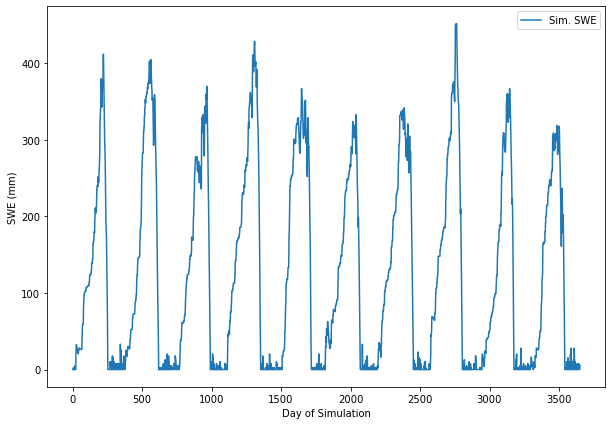

In [5]:
plt.figure(figsize=(10, 7))
plt.plot(snowpy_output,label='Sim. SWE')
plt.ylabel('SWE (mm)')
plt.xlabel('Day of Simulation')
plt.legend()
plt.show()
plt.close()

## 1.3 Sharing, modifying, coupling, and controlling (from a central framework) snowPy

Let's now return to imagining ourselves as hydrologists. If we were running a one-off study, having a single-file might be okay, but still not ideal. The problems only magnify if we consider the broader research to operations pathway. Let's enumerate the challenges with a few themes:

**Sharing**

1) There are no functions that describe the model. Yes, someone can read the comments. But what if they had to understand multiple models? What if each model comprised thousands of lines of code instead of less than 100?

**Modifying**

2) There is no way to change parameter values, file paths, etc. without changing the `.py` model file itself. What if you or a colleague want to deploy the model in a different location or over a different temporal extent and time step?

3) The only way to add new processes/capabilities to the model is to change the single file in the source code. There are no modules that can be swapped in and out. You can't call functions from a central driver or program. You cannot run unit tests (because there are no functional units to test).

**Coupling**

4) There are only two ways to couple this model: through soft coupling (running the model, saving its output, and using that as forcing for another model) or changing its source code entirely.

**Controlling**

5) A centralized framework (e.g., NextGen) cannot control model runtime in any standardized way.

# 2 The right way

Fortunately, we can remedy most of these issues by first making `snowPy` BMI compliant and then implementing the full set of BMI functions.

## 2.1 BMI background

The Community Surface Dynamics Modeling System ([CSDMS](https://csdms.colorado.edu/)) group at the University of Colorado Boulder develops and maintains BMI. You can find further information on the [BMI GitHub page](https://github.com/csdms/bmi) or on the [CSDMS Wiki](https://csdms.colorado.edu/wiki/BMI).

The two reference papers for BMI are:

- *Hutton, E.W., Piper, M.D., and Tucker, G.E., 2020. The Basic Model Interface 2.0: A standard interface for coupling numerical models in the geosciences. Journal of Open Source Software, 5(51), 2317, https://doi.org/10.21105/joss.02317.*
- *Peckham, S.D., Hutton, E.W., and Norris, B., 2013. A component-based approach to integrated modeling in the geosciences: The design of CSDMS. Computers & Geosciences, 53, pp.3-12, http://dx.doi.org/10.1016/j.cageo.2012.04.002.*

The CSDMS `heat` [example](https://github.com/csdms/bmi-example-python) is a great reference for BMI implementations. We based the `snowBMI` model, which we'll see shortly, heavily on the CSDMS examples. 

## 2.2 BMI philosophy

BMI is middleware, meaning it is software that operates between other components (in our case a centralized framework—NextGen—and a model). It standardizes model querying, control, and coupling. 

From the [BMI wiki](https://bmi.readthedocs.io/en/stable/): 

> We believe that numerical models, and the sub-components that make up those models, should offer…standardization. To this end, the Community Surface Dynamics Modeling System (CSDMS) has developed the Basic Model Interface (BMI): a set of **standard control and query functions** that, when added to a model code, make that model both easier to learn and easier to couple with other software elements.

And here's a brief, handy guide to what BMI does and does not do.

| BMI does… | BMI does not… |
| :-  | :-  |
| Control model runtime using standardized functions | Affect hydrologic model code|
| Pass data in/out of models using standardized functions | Perform unit conversions |
| Provide model and variable information | Perform spatial transforms |
| Work in multiple languages and models* | Provide information it’s not asked for |
|  | Optimize model output or runtime performance |
*You need a central framework like NextGen or other software for cross-language interoperability

## 2.3 Making a model BMI compliant

To be widely utilized, BMI does not prescribe many specific features that a model must have to be compliant. In brief, a model must:

- Be coded in a supported language
  - C, C++, Fortran, Python, Java
  - Or implement the standard in a new language
- Follow the initialize-update-finalize paradigm
- Employ separation of concerns
- Implement time loops in a BMI-compliant way
- Have state variables be accessible and settable

## 2.4 BMI functions

With our limited workshop time, we won't cover every function in detail and will instead focus on a few important categories. To learn more on your own, see the [BMI basics workshop repo](https://github.com/SnowHydrology/ciroh_workshop_2023/) or view the [BMI wiki](https://bmi.readthedocs.io/en/stable/#the-basic-model-interface).

CSDMS groups functions into six categories:

1. Model information functions
  - These describe the model and provide ancillary info like the number of input and output variables and their names
  - You can use [CSDMS standard names](https://csdms.colorado.edu/wiki/CSDMS_Standard_Names)
    - e.g. `atmosphere_water__precipitation_leq-volume_flux`
2. Variable information functions
  - These provide variable units, data types, and memory size
  - NextGen uses standard unit definitions from [UDUNITS](https://www.unidata.ucar.edu/software/udunits/) to perform automatic unit conversion
    - e.g. `meters`, `kg m-2`, `mm h-1`, `hours`, `degC`, etc.
3. Time functions
  - These provide the model time step, beginning time, current time, end time
4. Model control functions
  - These start the model, run the model, and finalize the model
5. Variable getter and setter functions
  - These get and set values for implemented model state variables
6. Model grid functions
  - These describe the model's spatial discretization

# 3 Implementing BMI

Now that we've seen the wrong way of doing things and had an introduction to BMI, we will walk through the transition from `snowPy` to `snowBMI`. 

## 3.1 Introducting snowBMI

`snowBMI` is an improved, modularized version of `snowPy` with a BMI implementation available [here on GitHub](https://github.com/SnowHydrology/snowBMI/). The snow accumulation and melt code (i.e., the hydrologic processes) are the same, but almost everything else is different and better.

For example, while `snowPy` used only a single file without any modularization. `snowBMI` breaks out the code into different files and modules. You can view the former in the directory structure below and we'll cover the latter shortly.

```
├── requirements.txt
├── setup.cfg
├── setup.py
└── snow
    ├── __init__.py
    ├── _version.py
    ├── bmi_snow.py
    └── snow.py
```

Although this simplified conversion will likely differ from the more complex steps needed for other models, you can use it as a template or best practice guide in your work.

## 3.2 Making your model BMI compliant

In [Section 2.3](#2.3-Making-a-model-BMI-compliant) above, we saw some of the features that make a model BMI compliant. We'll walk through those now.

### 3.2.1 Supported language

`snowPy` and `snowBMI` are both written in Python, a CSDMS-supported language. Other CSDMS-supported languages include C, C++, Java, and Fortran. All of those, except Java, are compatible with NextGen currently. 

There are additional community-supported languages, such as [JavaScript](https://github.com/uihilab/BMI-JS).

### 3.2.2 Initialize-update-finalize

BMI requires that your model follow the initialize-update-finalize paradigm. Most models do this already, but they may do it in ways (like `snowPy`) that make implementing BMI difficult.

#### 3.2.2.1 Initialize 

`snowBMI` eschews the hard-coded parameter values of `snowPy` and replaces them with a user-settable configuration YAML file called `snow.yaml`.

In addition, we've implemented other code that reads in the YAML file and populates the model object with its data.

```python
    @classmethod
    def from_file_like(cls, file_like):
        """Create a Snow object from a file-like object.

        Parameters
        ----------
        file_like : file_like
            Input parameter file.

        Returns
        -------
        Snow
            A new instance of a Snow object.
        """
        config = yaml.safe_load(file_like)
        return cls(**config)
```

#### 3.2.2.2 Update

In `snowPy` we wrote all of the hydrologic modeling code in the model's execution loop. That was not great. In `snowBMI`, we created two new functions. One is called `solve_snow` which comprises only snow accumulation and melt code. 

```python
def solve_snow(temp, precip, doy, swe, melt, rain_snow, rs_thresh, snow_thresh_max, rain_thresh_min,
               ddf_max, ddf_min, tair_melt_thresh):
    """Run the snow model for one time step to update the states and fluxes.

```

The other is called `advance_in_time` which calls `solve_snow` and then updates the model time based on the time step.

```python
def advance_in_time(self):
        """Run solve_snow and advance the model."""
```

#### 3.2.2.3 Finalize

Then we clear the model object in the finalize step (there was no equivalent step in `snowPy`). 

Importantly, we don't have any hard-coded data writing and instead rely on a calling program or central framework to write output in a standard way (more on this later).

### 3.2.3 Separation of concerns

We took care of separation of concerns, mostly, in the previous subsections. If you want your code to work effectively, you shouldn't mix processes across functions and modules. 

For example, you shouldn't have any initialize code in your update step. Otherwise, your model will be more difficult to understand and may produce unexpected behavior. 

### 3.2.4 Compliant time loops

Your model run function (equivalent to `advance_in_time` should execute only one model time step. You can then place that function inside a time loop in your driver.

**You should not have a time loop in your model run function.** If you do, your model will execute all time steps (even if it's not supposed to) when called by a centralized framework.

### 3.2.5 Accessible model state variables

In `snowPy` all variables had a global scope and a limited lifetime (only while the script was executing). For `snowBMI`, we converted the model to a package with a snow class populated by the model state variables we need access to. 

```python
class Snow(object):
    """Snow model class."""

    def __init__(
        self, rs_method=1, rs_thresh=2.5, snow_thresh_max=1.5, rain_thresh_min=4.5,
            ddf_max=1, ddf_min=0, tair_melt_thresh=1, swe_init=0, dayofyear=274, year=2016,
    ):

        self._rs_method = rs_method
        self._rs_thresh = rs_thresh
        self._snow_thresh_max = snow_thresh_max
        self._rain_thresh_min = rain_thresh_min
        self._ddf_max = ddf_max
        self._ddf_min = ddf_min
        self._tair_melt_thresh = tair_melt_thresh

        self._time = 0.0
        self._time_step = 86400
        self._dayofyear = dayofyear
        self._year = year

        self._tair_c = np.zeros(1, dtype=float)
        self._ppt_mm = np.zeros(1, dtype=float)
        self._swe_mm = np.zeros(1, dtype=float)
        swe_tmp = np.zeros(1, dtype=float)
        swe_tmp[0, ] = swe_init
        self._swe_mm = swe_tmp
        self._melt_mm = np.zeros(1, dtype=float)
```

This means that once the `snowBMI` model has been initialized, we can access the data using BMI functions, which we'll explore now.

## 3.3 Implementing BMI functions

As of this writing, there are 41 different functions in the BMI version 2.0 specification. Obviously we don't have time to cover all of them, so we'll cover some of the important ones for NextGen. 

NextGen does many things, but here are some highlights along with select (i.e., not all) relevant BMI functions:

1. It initializes models
  - `BMI::initialize()`
2. It controls model runtime
  - `BMI::update()`
3. It closes models when they're completed to free up memory and other resources
  - `BMI::finalize()`
4. It passes forcing data to models (and can pass data between coupled models in a stack)
  - `BMI::get_value()`, `BMI::set_value()`, `BMI::get_var_itemsize()`, `BMI::get_var_nbytes()`, `BMI::get_var_type()`
5. It can perform automated unit conversion when passing data
  - `BMI::get_var_units()`
6. It keeps the clock running for all models in an instance
  - `BMI::get_current_time()`, `BMI::get_time_step()`

We will discuss these further in the sections below. A few notes/reminders first:

- *You must implement all BMI functions even if they only return BMI_FAILURE* for BMI to work.
- *All necessary model functions must be wrapped inside or callable from a BMI function*. Otherwise, running the model with BMI won’t work (BMI can’t access what it doesn’t see).
- *For this example* you need to have the Python BMI bindings already installed to define the abstract base classes that `bmi_snow.py` extends in `snowBMI`.

For the full Python BMI specification, go to the [CSDMS GitHub page](https://github.com/csdms/bmi-python).

### 3.3.1 BMI::initialize()

The `initialize` function calls the previously defined `from_file_like` function to read in the configuration file and set initial model state and parameter values. 

You'll notice you don't have to move the `from_file_like` code to BMI--you can just call the already written function.

You could also copy and paste your initialization code into the BMI function, but that requires a lot more work and leads to messy BMI implementations that are hard to understand (it's also not very modular or portable). *Let BMI do BMI things and let model code do model things.*

The other thing this particular `initialize` function does is map the CSDMS standard names to the model variable names. We also give the UDUNITS-compliant units for each input and output variable. 

*Note: the model itself does not use these mappings. They instead facilitate the return of required information from subsequent BMI functions.*

``` python
def initialize(self, filename=None):
        """Initialize the model.

        Parameters
        ----------
        filename : str, optional
            Path to name of input file.
        """
        if filename is None:
            self._model = Snow()
        elif isinstance(filename, str):
            with open(filename, "r") as file_obj:
                self._model = Snow.from_file_like(file_obj.read())
        else:
            self._model = Snow.from_file_like(filename)

        self._values = {"atmosphere_water__precipitation_leq-volume_flux": self._model.ppt_mm,
                        "land_surface_air__temperature": self._model.tair_c,
                        "snowpack__liquid-equivalent_depth": self._model.swe_mm,
                        "snowpack__melt_volume_flux": self._model.melt_mm}
        self._var_units = {"atmosphere_water__precipitation_leq-volume_flux": "mm d-1",
                           "land_surface_air__temperature": "C",
                           "snowpack__liquid-equivalent_depth": "mm",
                           "snowpack__melt_volume_flux": "mm d-1"}
```

### 3.3.2 BMI::update()

Next we have a very short `update` function that calls `advance_in_time` which moves the model one time step and runs the `solve_snow` function we saw earlier. This is an example of a BMI function calling model functions that already existed.

*You should not copy and paste all of your model's code into the `update` function.* Yes, you can technically do that, but just don't.

``` python
def update(self):
        """Advance model by one time step."""
        self._model.advance_in_time()
```
### 3.3.3 BMI::finalize()

This is a simple function to implement for `snowBMI`, but lower-level languages with greater memory-handling challenges (I'm looking at you, C...) will be more complex.

```python
    def finalize(self):
        """Finalize model."""
        self._model = None
```

### 3.3.4 BMI::get_value() and BMI::set_value(), BMI::get_var_itemsize(), BMI::get_var_nbytes() ,  BMI::get_var_type()

The two main BMI getter/setter functions, `get_value` and `set_value`, do a lot of work in NextGen. The former returns the value(s) of a variable accessible via BMI, while the latter lets you change the value(s) of a variable. 

In order for these functions to work, you must have your variable names mapped correctly.

We'll see how these functions can be applied later in this notebook.

```python
def get_value(self, var_name, dest):
        """Copy of values.

        Parameters
        ----------
        var_name : str
            Name of variable as CSDMS Standard Name.
        dest : ndarray
            A numpy array into which to place the values.

        Returns
        -------
        array_like
            Copy of values.
        """
        dest[:] = self.get_value_ptr(var_name).flatten()
        return dest
```

```python
def set_value(self, var_name, src):
        """Set model values.

        Parameters
        ----------
        var_name : str
            Name of variable as CSDMS Standard Name.
        src : array_like
            Array of new values.
        """
        val = self.get_value_ptr(var_name)
        val[:] = src.reshape(val.shape)
```

For NextGen, you also need to provide fully implemented variable information functions. To control and couple models, the framework must know the size of one variable element in bytes (`get_var_itemsize`), the total memory required to store a variable (`get_var_nbytes`), and the type (e.g., integer, float, etc.) of a variable (`get_var_type`).

### 3.3.5 BMI::get_var_units()

If you map your units to your variables correctly (as we did above), then this function is a breeze.

```python
    def get_var_units(self, var_name):
        """Get units of variable.

        Parameters
        ----------
        var_name : str
            Name of variable as CSDMS Standard Name.

        Returns
        -------
        str
            Variable units.
        """
        return self._var_units[var_name]
```

Because NextGen uses this function to query a variable's units, it can use UDUNITS to perform automated unit conversion.

### 3.3.6 BMI::get_current_time() and BMI::get_time_step()

As with the function above, these two are particularly easy to implement but important to do so correctly.

```python

    def get_current_time(self):
        return self._model.time

    def get_time_step(self):
        return self._model.time_step
```

If you have `time` and `time_step` accessible in your model class, then NextGen can use BMI functions to keep the model clock correctly.

# 3.4 Putting it all together

What we've just done is taken a single Python script called `snowPy` and gone through a series of steps to make it compatible with BMI. 

We then implemented BMI functions, ending with a new Python package called `snowBMI` that can run in a centralized framework.

# 4 Running `snowBMI` with BMI commands

Before using NextGen, we'll first run `snowBMI` in standalone mode to get a closer look at how the BMI functions work.

## 4.1 Initialize

Let's first create an instance of the model with its BMI wrapper.

In [6]:
x = SnowBmi()

Let's take a look at the configuration file we'll use for `snowBMI` and then run the BMI `initialize` function.

In [7]:
cat snow.yaml

# Snow model configuration
rs_method: 1         # 1 = single threshold, 2 = dual threshold
rs_thresh: 2.5       # rain-snow temperature threshold when rs_method = 1 (degC)
snow_thresh_max: 1.5 # maximum all-snow temp when rs_method = 2 (degC)
rain_thresh_min: 4.5 # minimum all-rain temp when rs_method = 2 (degC)
ddf_max: 2           # maximum degree day melt factor (mm/day/degC)
ddf_min: 0           # minimum degree day melt factor (mm/day/degC)
tair_melt_thresh: 1  # air temperature threshold above which melt can occur (degC)
swe_init: 0          # initial snow water equivalent (mm)
dayofyear: 274       # Day of year of simulation start (ex: 1 = Jan 1, 274 = Oct 1)
year: 2012           # year of simulation start
timestep: 86400      # model time step (s)

In [8]:
x.initialize("snow.yaml")

## 4.2 Get info on the model

Now we can start using BMI functions to get key model information. First, we'll use the BMI `get_component_name` function.

In [9]:
print(x.get_component_name())

Temperature Index Snow Model with BMI


We can also use standardized BMI functions to get the number of input and output variables, along with their names.

In [10]:
print("There are", x.get_input_item_count(), "input variables")
print("Input vars =", x.get_input_var_names())
print("There are", x.get_output_item_count(), "output variables")
print("Output vars =", x.get_output_var_names())

There are 2 input variables
Input vars = ('atmosphere_water__precipitation_leq-volume_flux', 'land_surface_air__temperature')
There are 2 output variables
Output vars = ('snowpack__liquid-equivalent_depth', 'snowpack__melt_volume_flux')


We can get additional variable info using the other BMI var functions.

In [11]:
input_vars = x.get_input_var_names()
for tmp in input_vars:
    print(tmp, "with units of", x.get_var_units(tmp), "is a", x.get_var_type(tmp), 
          "variable that takes up", x.get_var_nbytes(tmp), "bytes of memory")

atmosphere_water__precipitation_leq-volume_flux with units of mm d-1 is a float64 variable that takes up 8 bytes of memory
land_surface_air__temperature with units of degC is a float64 variable that takes up 8 bytes of memory


Check the time information for the model.

In [12]:
print("Start time:", x.get_start_time())
print("End time:", x.get_end_time())
print("Current time:", x.get_current_time())
print("Time step:", x.get_time_step())
print("Time units:", x.get_time_units())

Start time: 0.0
End time: 1.7976931348623157e+308
Current time: 0.0
Time step: 86400
Time units: s


## 4.3 Get and set values

Let's now use standard BMI functions to get and set variable values.

First we'll play around with air temperature.

In [13]:
# when the model is initialized, air temperature equals 0
# we can check this using either get_value or get_value_ptr
temp_array = np.zeros(1,)
x.get_value('land_surface_air__temperature', temp_array)
print("Air temperature from get_value =", temp_array)
print("Air temperature from get_value_ptr =", x.get_value_ptr('land_surface_air__temperature'))

Air temperature from get_value = [0.]
Air temperature from get_value_ptr = [0.]


We see above that values from both functions are the same. Now we can set air temperature to a new value and confirm that it did indeed change.

In [14]:
# Now we can set the value of air temperature
# first make a numpy single-element array and give it a value
air_temperature = np.full(1, -5)

# Then set the value and check it with get_value
x.set_value("land_surface_air__temperature", air_temperature)
x.get_value('land_surface_air__temperature', temp_array)
print("Air temperature from get_value after set_value=", temp_array)
print("Air temperature from get_value_ptr after set_value=", x.get_value_ptr('land_surface_air__temperature'))

Air temperature from get_value after set_value= [-5.]
Air temperature from get_value_ptr after set_value= [-5.]


And let's do the same for precipitation

In [15]:
precip = np.full(1, 10)
print("Precipitation from get_value_ptr =", x.get_value_ptr("atmosphere_water__precipitation_leq-volume_flux"))
x.set_value("atmosphere_water__precipitation_leq-volume_flux", precip)
print("Precipitation from get_value_ptr after set_value=", x.get_value_ptr('atmosphere_water__precipitation_leq-volume_flux'))

Precipitation from get_value_ptr = [0.]
Precipitation from get_value_ptr after set_value= [10.]


A key advantage of BMI is that **we don't have to know the names of any of the input or output variables**. We can query the model and have standardized BMI functions return their names and values (and even their units!). This means no more spending hours poring over code to get the simplest info—you can use the same functions over and over again to get the info you require.

In [16]:
# we can also look at all values with a loop
input_vars = x.get_input_var_names()
for tmp in input_vars:
    print(tmp, "=", x.get_value_ptr(tmp), x.get_var_units(tmp))
output_vars = x.get_output_var_names()
for tmp in output_vars:
    print(tmp, "=", x.get_value_ptr(tmp), x.get_var_units(tmp))

atmosphere_water__precipitation_leq-volume_flux = [10.] mm d-1
land_surface_air__temperature = [-5.] degC
snowpack__liquid-equivalent_depth = [0.] mm
snowpack__melt_volume_flux = [0.] mm d-1


# 4.4 Run the model with real SNOTEL forcing

Although it's fun to look at printed data and manually get/set values, let's try running an example simulation now using real forcing data from a SNOTEL station. First, we'll finalize and then reinitialize the model.

In [17]:
# Finalize the model
x.finalize()

# Reinitialize the model
x.initialize("snow.yaml")

Now let's a look at the variables again to confirm they're reset.

In [18]:
input_vars = x.get_input_var_names()
for tmp in input_vars:
    print(tmp, "=", x.get_value_ptr(tmp), x.get_var_units(tmp))
output_vars = x.get_output_var_names()
for tmp in output_vars:
    print(tmp, "=", x.get_value_ptr(tmp), x.get_var_units(tmp))

atmosphere_water__precipitation_leq-volume_flux = [0.] mm d-1
land_surface_air__temperature = [0.] degC
snowpack__liquid-equivalent_depth = [0.] mm
snowpack__melt_volume_flux = [0.] mm d-1


Yep, everything's back to zero, so let's import and view the forcing data.

In [19]:
# Import the example SNOTEL data
forcing = pd.read_csv("../data/snotel_663_data.csv")
print(forcing.head(10))

         date  swe_mm  tair_c  ppt_mm
0  2012-10-01     0.0     5.4     0.0
1  2012-10-02     0.0    10.6     0.0
2  2012-10-03     0.0     7.5     0.0
3  2012-10-04     0.0    -1.1     0.0
4  2012-10-05     0.0    -1.3     0.0
5  2012-10-06     0.0    -5.6     0.0
6  2012-10-07     0.0    -0.5     2.5
7  2012-10-08     0.0     5.2     0.0
8  2012-10-09     0.0     3.9     0.0
9  2012-10-10     0.0     6.8     0.0


We can see in the dataframe above that we have everything we need to run `snowBMI`, specifically air temperature and precipitation.

Now we can run a `snowBMI` update loop based on the number of entries in the forcing data. Importantly, we'll use `BMI::set_value` to apply the forcing data to the model and `BMI::get_value` to access model data for plotting and analysis.

In [20]:
# Make an empty array to store the output data
swe_output = np.zeros(forcing.date.size)

# Loop through the data and run snowBMI
for i in range(forcing.date.size):
    air_temperature = np.full(1, forcing.tair_c[i])
    precip = np.full(1, forcing.ppt_mm[i])
    x.set_value("land_surface_air__temperature", air_temperature)
    x.set_value("atmosphere_water__precipitation_leq-volume_flux", precip)
    x.update()
    swe_output[i] = x.get_value_ptr("snowpack__liquid-equivalent_depth")

## 4.5 Plot and evaluate the model output

Now we can compare the observed SWE to the simulated.

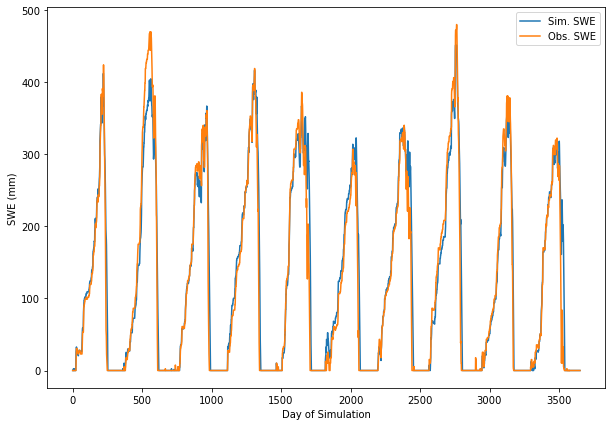

In [21]:
# Plot the simulated and observed SWE
plt.figure(figsize=(10, 7))
plt.plot(swe_output,label='Sim. SWE')
plt.plot(forcing.swe_mm, label='Obs. SWE')
plt.ylabel('SWE (mm)')
plt.xlabel('Day of Simulation')
plt.legend()
plt.show()
plt.close()

All in all, that's a pretty good result for a non-calibrated temperature index snow model that completely ignores snow hydrology and runs on a daily time step. In fact, we can calculate its Nash Sutcliffe efficiency (NSE) and mean bias. 

In [22]:
# Calculate and print NSE
obs = forcing.swe_mm
sim = swe_output
nse_denominator = ((obs - obs.mean())**2).sum()
nse_numerator = ((sim - obs)**2).sum()
nse = 1 - nse_numerator / nse_denominator
print("NSE: {:.2f}".format(nse))

# Calculate mean bias
mean_bias = sim.mean() - obs.mean()
print("Mean bias: {:.2f}".format(mean_bias), "mm")

NSE: 0.94
Mean bias: 4.68 mm


If only all of our models could be so good! Okay, let's end this and finalize our run.

In [23]:
x.finalize()

**But that's not all!!!**

# 5 Running your model from a framework

The real power of BMI is not running your model in standalone mode. Yes, BMI in that context has many advantages, such as easily queryable model information, standardized commands, etc. Buuut, what makes BMI so great is that it lets you run your model from a centralized framework—like NextGen—opening up a world of opportunities, such as:

- Using standardized forcing and geospatial data
- Making like-to-like comparisons with other models
- Easily modifying and/or expanding spatial/temporal domains
- Coupling with other models

So what we're going to do now is deploy our model in NextGen in a different spatial domain, time period, and discretization.

## 5.1 Setting up NextGen

*Note 1: You don't need to execute any of these steps for this notebook to run. We include the information here in case you want to set up and execute your own experiments.*

*Note 2: This is a very high-level overview of the steps you need to perform to build and run NextGen. Please see other resources (e.g., the [GitHub page](https://github.com/NOAA-OWP/ngen/) and [wiki](https://github.com/NOAA-OWP/ngen/wiki/)) for more info.*

First, we need to set up our own instance of NextGen. We do this by cloning the framework from GitHub.

```bash
git clone https://github.com/NOAA-OWP/ngen.git
```

Then you can follow the NextGen build instructions in the [wiki](https://github.com/NOAA-OWP/ngen/wiki/NGen-Tutorial). Importantly, you'll need to set `-DNGEN_WITH_PYTHON:BOOL=ON` for Python models to run.

You'll also need to set up a virtual environment for running Python models. For this experiment:

```bash
python -m venv ngen_venv
source ngen_venv/bin/activate
pip install numpy pandas pyyaml bmipy
```

And don't forget to build the models you need into the virtual environment. (For us, that is `snowBMI` and `linearresBMI`. More on the latter in just a minute.) You do this by running the following from their source directory:

```bash
pip install -e .
```

And you can check the contents of your environment with `pip list`.

## 5.2 Our domain

For this experiment, we're going to run NextGen in the Merced River headwaters on the western slope of California's Sierra Nevada in Yosemite National Park.

![image.png](images/merced_basin_map.png)

The subbasins in the Merced range in elevation from 1714 m to 3484 m with average annual precipitation between 850 mm to 1270 mm and annual snowfall fractions from 44.4% to 94.4%.

We are using processed Analysis of Record for Calibration (AORC) forcing data and geospatial data from the [NextGen hydrofabric](https://www.lynker-spatial.com/). 

For this demonstration, we are going to run `snowBMI` in NextGen for water year 2008 (2007-10-01 through 2008-09-30).

## 5.3 Our configuration file(s)

To run a model in NextGen, you generally need two configuration files. One is the NextGen realization configuration and the other is your model's configuration file.

That means we need a `realization.json` file for NextGen and a version of `snow.yaml` for `snowBMI`.

Our specific NextGen realization file looks like this:

```json
{
    "global": {
        "formulations": [
                {
                    "name": "bmi_python",
                    "params": {
                                "python_type": "snow.SnowBmi",
                                "model_type_name": "bmi_python_snowBMI",
                                "init_config": "./data/snowbmi_merced.yaml",
                                "allow_exceed_end_time": true,
                                "main_output_variable": "snowpack__liquid-equivalent_depth",
                                "uses_forcing_file": false,
                                "variables_names_map" : {
                                                                "atmosphere_water__precipitation_leq-volume_flux" : "atmosphere_water__liquid_equivalent_precipitation_rate"
                                                        }
                    }
                }
        ],
        "forcing": {
            "file_pattern": "{{id}}.csv",
            "path": "./forcing/",
            "provider": "CsvPerFeature"
        }
    },
    "time": {
        "start_time": "2007-10-01 00:00:00",
        "end_time": "2008-09-30 00:00:00",
        "output_interval": 3600
    }
}
```

A fully detailed discussion of its contents is outside the time of this presentation, but please check out the [wiki page](https://github.com/NOAA-OWP/ngen/wiki/Realization-Config) for more info.

And our `snow.yaml` looks like this:

```yaml
# Snow model configuration
rs_method: 1         # 1 = single threshold, 2 = dual threshold
rs_thresh: 2.5       # rain-snow temperature threshold when rs_method = 1 (deg C)
snow_thresh_max: 1.5 # maximum all-snow temp when rs_method = 2 (deg C)
rain_thresh_min: 4.5 # minimum all-rain temp when rs_method = 2 (deg C)
ddf_max: 2           # maximum degree day melt factor (mm/day/deg C)
ddf_min: 0           # minimum degree day melt factor (mm/day/deg C)
tair_melt_thresh: 1  # air temperature threshold above which melt can occur (deg C)
swe_init: 0          # initial snow water equivalent (mm)
dayofyear: 274       # Day of year of simulation start (ex: 1 = Jan 1, 274 = Oct 1)
year: 2007           # year of simulation start
timestep: 3600      # model time step (s)
```

You'll notice that all we had to do to change the model's timestep was correctly provide that information in both configuration files.

## 5.4 Running `snowBMI` in NextGen

With NextGen built, our virtual environment set up, forcing and hydrofabric data loaded, and configuration files generated, we can now run NextGen with a pretty simple command:

```bash

../cmake_build/ngen ./spatial/catchment_data.geojson '' ./spatial/nexus_data.geojson '' realization_merced.json

```

And then wait while the magic happens.

```
NGen Framework 0.1.0
Building Nexus collection
Building Catchment collection
Initializing formulations
Not Using Routing
Building Feature Index
Catchment topology is dendritic.
Running Models
Updating layer: surface layer
Running timestep 0
Updating layer: surface layer
Running timestep 100
Updating layer: surface layer
Running timestep 200
Updating layer: surface layer
Running timestep 300

...

```

## 5.5 Examining NextGen output

Running NextGen produces a series of output files, corresponding to each catchment, a subset of which is shown below.

```R
  [1] "cat-10.csv"               "cat-101.csv"              "cat-108.csv"             
  [4] "cat-110.csv"              "cat-113.csv"              "cat-114.csv"             
  [7] "cat-115.csv"              "cat-120.csv"              "cat-124.csv"             
 [10] "cat-125.csv"              "cat-127.csv"              "cat-13.csv"              
 [13] "cat-130.csv"              "cat-134.csv"              "cat-136.csv" 
 ```
 
 Importantly, the output format is standardized across models, making for easy, reproducible analyses. It also means that with BMI and NextGen we have just dramatically expanded the power of our model and evaluation. 
 
 Instead of looking at a single niveograph, we can now summarize all of the catchments from our Merced domain and plot the minimum, average, and maximum simulated snow water equivalent (SWE) for each day in the study period.
 
![image.png](images/merced_min_avg_max_swe_plot.png)

What's more, we can use the spatial information from the NextGen hydrofabric to map out the maximum SWE during water year 2008 in each catchment.

![image](images/merced_basin_max_swe_map.png)

Again, we haven't changed our model from standalone to NextGen mode! All we've done is update a couple configuration files.

**But that's not all!**

## 5.6 Coupling models in NextGen

Remember how we said we could couple models using NextGen? Well, it turns out that is relatively straightforward.

In our particular case, we've just run `snowBMI`, which is great, but snow accumulation and melt are only part of the hydrologic balance. 

In the past, the coupling process could take weeks to months of refactoring model code and painfully stitching together two independently developed models (if it were possible at all). BMI and NextGen, yet again, standardize the process for easy modeling coupling.

Let's demonstrate this now using `linearresBMI`, which is a linear reservoir model to simulate discharge, available [here on GitHub](https://github.com/SnowHydrology/linearresBMI/). 

**Note,** in this case, our linear reservoir assumes all incoming water fluxes exit the model domain as discharge (i.e., we're not representing evapotranspiration or aquifer recharge). 

*Please don't think this silly model will produce accurate results. It just won't unless your research domain is an actual bucket.*

### 5.6.1 Updating the realization config

We're going to keep our forcing data, hydrofabric, `snowBMI` config, and almost everything else the same for our coupled simulation. The main exception is the realization config, which we update to include `linearresBMI`.

```json
{
    "global": {
        "formulations": [
            {
                "name": "bmi_multi",
                "params": {
                    "model_type_name": "bmi_multi_snow_linres",
                    "forcing_file": "",
                    "init_config": "",
                    "allow_exceed_end_time": true,
                    "main_output_variable": "land_surface_water__runoff_volume_flux",
                    "modules": [
                        {
                            "name": "bmi_python",
                            "params": {
                                "python_type": "snow.SnowBmi",
                                "model_type_name": "bmi_python_snowBMI",
                                "init_config": "./data/snowbmi_merced.yaml",
                                "allow_exceed_end_time": true,
                                "main_output_variable": "snowpack__liquid-equivalent_depth",
                                "uses_forcing_file": false,
                                "variables_names_map" : {
                                                                "atmosphere_water__precipitation_leq-volume_flux" : "atmosphere_water__liquid_equivalent_precipitation_rate"
                                                        }
                            }
                        },
                        {
                            "name": "bmi_python",
                            "params": {
                                "python_type": "linearres.LinearresBmi",
                                "model_type_name": "bmi_python_linearres",
                                "init_config": "./data/linearres_cat-27.yaml",
                                "allow_exceed_end_time": true,
                                "main_output_variable": "land_surface_water__runoff_volume_flux",
                                "uses_forcing_file": false,
                                "variables_names_map" : {
                                                                "atmosphere_water__precipitation_leq-volume_flux" : "snowpack__melt_volume_flux"
                                                        }
                            }
                        }
                        
                    ],
                    "uses_forcing_file": false
                }
            }
        ],
        "forcing": {
            "file_pattern": "{{id}}.csv",
            "path": "./forcing/",
            "provider": "CsvPerFeature"
        }
    },
    "time": {
        "start_time": "2007-10-01 00:00:00",
        "end_time": "2008-09-30 00:00:00",
        "output_interval": 3600
    }
}

```

Even then, a lot of the info is the same, but a key thing here is we have a `multi-bmi` configuration and we map the snowmelt output from `snowBMI` as the precipitation input for `linearresBMI`. Magic!

### 5.6.2 Running the coupled models in NextGen

We even get to reuse the run command from earlier.

```bash
../cmake_build/ngen ./spatial/catchment_data.geojson '' ./spatial/nexus_data.geojson '' realization_merced.json
```

And then we wait for NextGen to do its thing. (I'll skip showing the screen output because it's the same as last time. Ditto for the output files.)


### 5.6.3 Examining the coupled model output

Just as we summarized the daily catchment SWE, we can look at the daily minimum, average, and maximum discharge from each NextGen catchment.

![image.png](images/merced_min_avg_max_discharge_plot.png)

With that, our demo is complete.

# 6 Wrap-Up

What have we covered here? A brief synopsis of what we've learned:

1. How *not* to create a model
2. How to properly create a model for interoperability and reproducibility
3. What BMI is and what its capabilities are
4. How to make a model BMI compliant and implement the standard
5. How to query and control a model with BMI
6. How to use NextGen and BMI-enabled models to run single-model and coupled simulations 

Feel free to contact Keith or Nels using the resources up top if you have any questions (or if you see any bugs in the code). Until we meet again, please take a look through the BMI and NextGen references below. Thanks! 

# References and further reading (and watching)

- [BMI](https://csdms.colorado.edu/wiki/BMI) from CSDMS
- The BMI Python [heat](https://github.com/csdms/bmi-example-python) example
- *Hutton, E.W., Piper, M.D., and Tucker, G.E., 2020. The Basic Model Interface 2.0: A standard interface for coupling numerical models in the geosciences. Journal of Open Source Software, 5(51), 2317, https://doi.org/10.21105/joss.02317.*
- *Peckham, S.D., Hutton, E.W., and Norris, B., 2013. A component-based approach to integrated modeling in the geosciences: The design of CSDMS. Computers & Geosciences, 53, pp.3-12, http://dx.doi.org/10.1016/j.cageo.2012.04.002.*
- Temperature index snow models like Snow-17 and the equations in DeWalle and Rango (2008)
    - _Anderson, E. A. "Snow accumulation and ablation model–SNOW-17." US National Weather Service, Silver Spring, MD 61 (2006)._
    - _DeWalle, David R., and Albert Rango. Principles of Snow Hydrology. Cambridge University Press, 2008._
- Wikipedia's entry on [runoff models](https://en.wikipedia.org/wiki/Runoff_model_(reservoir)) (yes, that Wikipedia)
    - The linear reservoir equation cites this document: *J.W. de Zeeuw, 1973. Hydrograph analysis for areas with mainly groundwater runoff. In: Drainage Principle and Applications, Vol. II, Chapter 16, Theories of field drainage and watershed runoff. p 321-358. Publication 16, International Institute for Land Reclamation and Improvement (ILRI), Wageningen, The Netherlands.* (good luck finding it!)
- The Next Generation Water Prediction Capability project at the NOAA-NWS Office of Water Prediction
   - GitHub repo for the [NextGen Framework](https://github.com/NOAA-OWP/ngen)
   - BMI implementation of the [LSTM](https://github.com/NOAA-OWP/lstm/) machine learning model
   - [CUAHSI Town Hall with NOAA’s National Water Center](https://www.youtube.com/watch?v=pPUyhmj2mFM)
